# Ejercicio de Repaso - Redes Neuronales Artificiales

In [1]:
## Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as python_random

## Librerias para modelos de ML
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Librerias para redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

2024-05-29 18:15:25.562887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def reset_seeds():
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(123)

## Lectura de los datos

In [3]:
## Cargar datos
data = datasets.fetch_california_housing(as_frame=True).frame
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
## Pre procesamiento de los datos

# Eliminacion de variables irrelevantes
df = data.drop(columns=['Latitude', 'Longitude']).copy()

## Separación de X y y
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

X.shape, y.shape

((20640, 6), (20640,))

In [7]:
## Escalado de los datos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Separación de los splits de datos: train/val/test - 70%/21%/9%
X_train, X_rem, y_train, y_rem = train_test_split(X_sc, y, train_size=0.7, random_state=0) 

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.3, random_state=0)

# Tamaños de los splits definidos
print("Conjunto de entrenamiento: ", X_train.shape, y_train.shape)
print("Conjunto de validación: ", X_val.shape, y_val.shape)
print("Conjunto de test: ", X_test.shape, y_test.shape)

Conjunto de entrenamiento:  (14447, 6) (14447,)
Conjunto de validación:  (4335, 6) (4335,)
Conjunto de test:  (1858, 6) (1858,)


In [8]:
## Definición de la ANN base
reset_seeds()

## definición de hiperparámetros iniciales
dor = 0.3
sr = 0.1
l2 = keras.regularizers.l2(sr)

## ANN1
ann1 = keras.models.Sequential(
    [
        keras.Input(shape=(6,)),
        keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dropout(dor),
        keras.layers.Dense(16, activation = 'tanh'),
        keras.layers.Dense(1, activation = 'relu')
    ]
)

m1 = keras.metrics.MeanAbsolutePercentageError(name='mape')

ann1.compile(
    optimizer= 'adam',
    loss = keras.losses.MeanSquaredError(),
    metrics = m1
)

history = ann1.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))



2024-05-29 18:49:42.296249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
452/452 [==============================] - 3s 3ms/step - loss: 1.0495 - mape: 36.4693 - val_loss: 0.6194 - val_mape: 35.2520
Epoch 2/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5651 - mape: 31.3816 - val_loss: 0.5530 - val_mape: 32.3284
Epoch 3/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5336 - mape: 30.9542 - val_loss: 0.5344 - val_mape: 35.3100
Epoch 4/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5178 - mape: 30.7997 - val_loss: 0.5120 - val_mape: 29.1174
Epoch 5/30
452/452 [==============================] - 1s 3ms/step - loss: 0.5053 - mape: 30.4432 - val_loss: 0.5030 - val_mape: 30.3289
Epoch 6/30
452/452 [==============================] - 1s 2ms/step - loss: 0.5033 - mape: 30.6436 - val_loss: 0.4967 - val_mape: 30.1802
Epoch 7/30
452/452 [==============================] - 1s 3ms/step - loss: 0.4907 - mape: 30.2240 - val_loss: 0.4844 - val_mape: 31.3010
Epoch 8/30
452/452 [============================

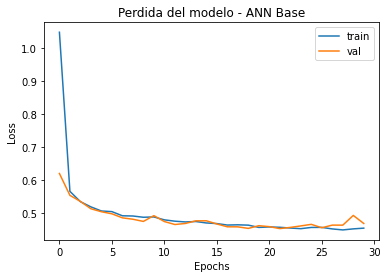

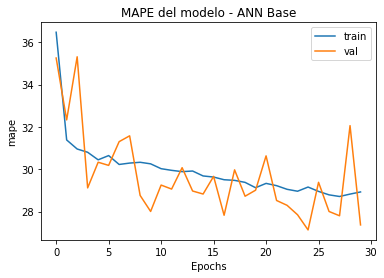

In [11]:
### Visualización de las curvas de error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo - ANN Base')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

### Visualización de las curvas de accuracy
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('MAPE del modelo - ANN Base')
plt.xlabel('Epochs')
plt.ylabel('mape')
plt.legend(['train', 'val'])
plt.show()

## Tuning de la ANN Base

In [12]:
### Definición de hiperparámetros
hp = kt.HyperParameters()
lo = keras.losses.MeanSquaredError()
m2 = keras.metrics.MeanAbsolutePercentageError(name = 'prueba')

In [20]:
def tun_model(hp):
    dor = hp.Float('DOR', min_value=0.1, max_value=0.4, step=0.1)
    opt = hp.Choice('OPT', ['adam', 'adamax', 'sgd'])
    units_1 = hp.Int('UNITS_1', min_value = 64, max_value=512, step=32)

    ann = keras.models.Sequential(
        [
            keras.Input(shape=(6,)),
            keras.layers.Dense(units= units_1, activation = 'relu', kernel_regularizer = l2),
            keras.layers.Dense(64, activation = 'relu'),
            keras.layers.Dropout(dor),
            keras.layers.Dense(16, activation = 'tanh'),
            keras.layers.Dense(1, activation = 'relu')
        ]
    )

    if opt == 'adam':
        opt = keras.optimizers.Adam(learning_rate=0.0001)
    elif opt == 'adamax':
        opt = keras.optimizers.Adamax(learning_rate=0.0001)
    else:
        opt = keras.optimizers.SGD(learning_rate=0.0001)
    
    ann.compile(optimizer=opt, loss=lo, metrics=m2)

    return ann

In [22]:
reset_seeds()

# Definción del Tuner
search_model = kt.RandomSearch(
    hypermodel= tun_model,
    hyperparameters = hp,
    objective= kt.Objective('prueba', direction="min"),
    max_trials=20,
    directory="results_tuner",
    project_name="california_housing"
)

# Ejecutar tuner
search_model.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Trial 20 Complete [00h 00m 21s]
prueba: 41.21118927001953

Best prueba So Far: 29.355607986450195
Total elapsed time: 00h 08m 22s


In [24]:
## Summary de la búsqueda
search_model.results_summary()

Results summary
Results in results_tuner/california_housing
Showing 10 best trials
Objective(name="prueba", direction="min")

Trial 09 summary
Hyperparameters:
DOR: 0.2
OPT: adam
UNITS_1: 288
Score: 29.355607986450195

Trial 06 summary
Hyperparameters:
DOR: 0.30000000000000004
OPT: adam
UNITS_1: 448
Score: 29.67861557006836

Trial 11 summary
Hyperparameters:
DOR: 0.4
OPT: adam
UNITS_1: 288
Score: 29.84110450744629

Trial 13 summary
Hyperparameters:
DOR: 0.1
OPT: adamax
UNITS_1: 448
Score: 30.20045280456543

Trial 17 summary
Hyperparameters:
DOR: 0.30000000000000004
OPT: adam
UNITS_1: 64
Score: 30.31757164001465

Trial 05 summary
Hyperparameters:
DOR: 0.1
OPT: adamax
UNITS_1: 288
Score: 30.47669792175293

Trial 02 summary
Hyperparameters:
DOR: 0.2
OPT: adamax
UNITS_1: 480
Score: 30.6039981842041

Trial 16 summary
Hyperparameters:
DOR: 0.1
OPT: adamax
UNITS_1: 256
Score: 30.65333366394043

Trial 04 summary
Hyperparameters:
DOR: 0.1
OPT: adamax
UNITS_1: 320
Score: 30.804611206054688

Tria

In [25]:
## Separación del mejor modelo
best_model = search_model.get_best_models()[0]
hps = search_model.get_best_hyperparameters()[0]
hps.values

{'DOR': 0.2, 'OPT': 'adam', 'UNITS_1': 288}

In [26]:
## Summary del modelo
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               2016      
                                                                 
 dense_1 (Dense)             (None, 64)                18496     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 21,569
Trainable params: 21,569
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Evaluación de la red con X_val
pred_1 = best_model.predict(X_val)
pred_1.shape

136/136 [==============================] - 0s 2ms/step


(4335, 1)

In [28]:
y_pred_1 = np.array(pred_1)[:,0]
y_pred_1

array([1.4532347, 2.2666516, 0.7310684, ..., 3.248332 , 3.046946 ,
       3.6755843], dtype=float32)

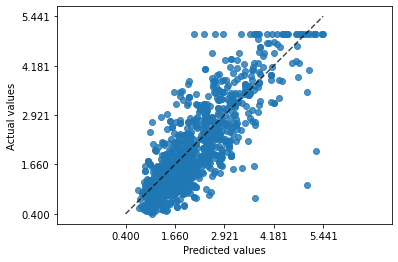

In [29]:
import sklearn.metrics as metrics

metrics.PredictionErrorDisplay.from_predictions(y_true = y_val, y_pred= y_pred_1, kind='actual_vs_predicted')

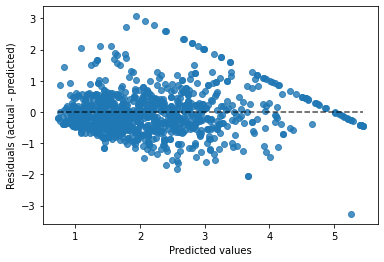

In [30]:
metrics.PredictionErrorDisplay.from_predictions(y_true = y_val, y_pred= y_pred_1, kind='residual_vs_predicted')

In [32]:
# Evaluación de la red con X_val
pred_2 = best_model.predict(X_test)
y_pred_2 = np.array(pred_2)[:,0]

59/59 [==============================] - 0s 2ms/step


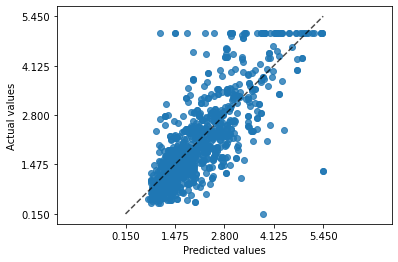

In [34]:
metrics.PredictionErrorDisplay.from_predictions(y_true = y_test, y_pred= y_pred_2, kind='actual_vs_predicted')

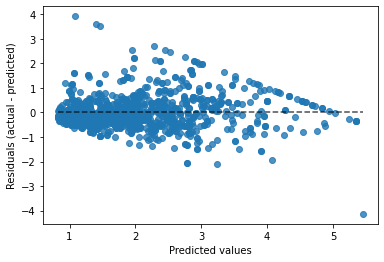

In [35]:
metrics.PredictionErrorDisplay.from_predictions(y_true = y_test, y_pred= y_pred_2, kind='residual_vs_predicted')